# Sergey Version

Using cilindrical coordinates we can express the velocity as a sum of $V_R$, $V_Z$ components, radial and z-component. Given a galactocentric latitud angle of ejection $\phi_{ej}$ the components of the velocity will be given by the orbit as a function of time and initial conditions:

$$ V_R(\phi_{ej}, V_{ej}, t) $$ 
$$ V_z(\phi_{ej}, V_{ej}, t) $$

This is just saying that they are a function of the position of the orbit, which is a function of time and initial conditions. Radius is also a function of time, so both functions can also be expressed as a function of radius. In the same way there is only one ejection angle that given an ejection velocity will give you the same orbit. 

Given the orbit we can compute the correction to the implied distance by:

$$ D = D_I - \frac{V_z \hat{n} \cdot (R_O \times e_z)}{(\hat{n} \cdot (R_0 \times \mu))}$$ 


In [133]:
# imports 
import numpy as np
import astropy.units as u
import astropy.coordinates as coord
from numba import njit
from astropy.table import Table
import os
import astropy
import pandas as pd
from tqdm import tqdm

# Define the vectors that are constant for the Milky Way
def compute_R0_V0_SI():
    """
    Define the position and velocity of the Galactic Center in Galactocentric frame
    Here, we're using the position of the Sun in the Galactocentric frame,
    which by definition is at (x, y, z) = (0, 0, 0) in Galactocentric coordinates.
    We then transform this to the ICRS frame to get the position and velocity vectors.

    input:
        None
    output:
        R0: position vector pointing from the Galactic Center to the Sun in ICRS frame
        V0: velocity vector of the Sun in ICRS frame
    """
    galcen_coord = coord.Galactocentric(
        x=0 * u.kpc,
        y=0 * u.kpc,
        z=0 * u.kpc,
        v_x=0 * u.km / u.s,
        v_y=0 * u.km / u.s,
        v_z=0 * u.km / u.s
    )
    # Transform to ICRS frame
    icrs_coord = galcen_coord.transform_to(coord.ICRS())
    # Get the position and velocity in ICRS frame (in SI units)
    X0 = icrs_coord.cartesian.xyz.to(u.m).value  # position in meters
    V0 = icrs_coord.velocity.d_xyz.to(u.m / u.s).value  # velocity in m/s

    # Get the vector pointing from the Galactic Center to the Sun in ICRS frame
    R0 = -X0  # Shape (3,)
    V0 = -V0  # Shape (3,)
    return R0, V0

def compute_e_z_SI():
    """
    Get the unit vector for the Galactocentric Z in ICRS frame.

    input:
        None
    output:
        ez: unit vector pointing from the Galactic Center to the North Galactic Pole in ICRS frame
    """
    galcen_coord = coord.Galactocentric(
        x=0 * u.kpc,
        y=0 * u.kpc,
        z=1 * u.kpc,
        v_x=0 * u.km / u.s,
        v_y=0 * u.km / u.s,
        v_z=0 * u.km / u.s
    )
    # Transform to ICRS frame
    icrs_coord = galcen_coord.transform_to(coord.ICRS())
    # Get the position and velocity in ICRS frame (in SI units)
    X0 = icrs_coord.cartesian.xyz.to(u.m).value  # position in meters

    # Get the vector pointing from the Galactic Center to the Sun in ICRS frame
    ez = X0  # Shape (3,)

    # Normalize the vector
    ez /= np.linalg.norm(ez)

    return ez



def cross_2D(a, b):
    """
    Vectorized cross product for two arrays of shape (N,3),
    returning shape (N,3).
    """
    return np.column_stack((
        a[:,1]*b[:,2] - a[:,2]*b[:,1],
        a[:,2]*b[:,0] - a[:,0]*b[:,2],
        a[:,0]*b[:,1] - a[:,1]*b[:,0]
    ))

def dot_2D(a, b):
    """
    Vectorized dot product for two arrays of shape (N,3),
    returning shape (N,).
    """
    return a[:,0]*b[:,0] + a[:,1]*b[:,1] + a[:,2]*b[:,2]


In [134]:
#  write a function that computes the extra term given R0, mu, n and Vz, ez

def compute_extra_term(R0, mu, n, Vz, ez):
    """
    Computes the correction term for the implied distance by considering a velocity component in the galactic Z direction

    Parameters:
        R0 (array): Vector from the galactic center to the sun in the ICRS coordinate system and SI units
        mu (array): Proper motion of the star in the ICRS coordinate system and SI units
        n (array): Normal vector from the sun to the source in the ICRS coordinate system (unit vector, from RA, DEC)
        Vz (float): Velocity component in the galactic Z direction in SI units
        ez (array): Unit vector in the galactic Z direction (orthogonal to the plane of the disk) in the ICRS coordinate system
    
    Returns:
        float: The correction term for the implied distance
    """
    r0xez = cross_2D(R0, ez)
    n_r0xez = dot_2D(n, r0xez)
    r0xmu = cross_2D(R0, mu)
    n_r0xmu = dot_2D(n, r0xmu)

    return Vz*(n_r0xez / n_r0xmu )

def extra_term_o(Omega, n, mu, R0):
    return np.dot(n, Omega)/np.dot(R0, np.cross(n, mu))

def extra_term_vectorized(Omega, n, mu, R0):
    return dot_2D(n, Omega) / dot_2D(R0, cross_2D(n, mu))

# Build interpolator

This interpolator should take as input a source cylindrical coordinates R, z and velocities V_R and V_z and return the V_z velocity that the orbit predicts at that position. 

First we need to turn our precomputed orbits from a $V_z(\phi_{ej}, v_{ej}, t)$ to a function of current observables $Vz(R, z, V)$ 

In [122]:
import gala.potential as gp
import gala.integrate as gi
import gala.dynamics as gd
import astropy.units as auni
import astropy.coordinates as acoo
import numpy as np

pot = gp.MilkyWayPotential2022()
kms = auni.km / auni.s

acoo.galactocentric_frame_defaults.set('latest')


def doit(vej, cosang, t):
    #cosang = np.cos(ang)
    #sinang = np.sin(ang)
    sinang = np.sqrt(1 - cosang**2)
    startpos = np.array([cosang, 0, sinang]) * auni.kpc
    vel = np.array([cosang, 0, sinang]) * vej
    w0 = gd.PhaseSpacePosition(startpos, vel=vel * kms)
    nsteps = 1000
    timestep = t * auni.Myr / nsteps
    orbit = gp.Hamiltonian(pot).integrate_orbit(
        w0,
        dt=timestep,
        n_steps=nsteps,
        Integrator=gi.DOPRI853Integrator,
        # Integrator_kwargs = dict(atol=1e-15,rtol=1e-15)
    )
    R = (orbit.x**2 + orbit.z**2 + orbit.y**2)**.5
    z = orbit.z.to_value(auni.kpc)
    VR = orbit.v_x * R / orbit.x
    Vz = orbit.v_z - orbit.v_x * orbit.z / orbit.x
    return R.to_value(auni.kpc), z, VR.to_value(kms), Vz.to_value(kms), orbit.t.to_value(auni.Myr), orbit.x.to_value(auni.kpc), orbit.y.to_value(auni.kpc), orbit.z.to_value(auni.kpc), orbit.v_x.to_value(kms), orbit.v_y.to_value(kms), orbit.v_z.to_value(kms)


def doall(N=10000, seed=3):
    rng = np.random.default_rng(seed)
    vej = 10**rng.uniform(2.8, 4, size=N)
    cosa = rng.uniform(0, 1, size=N)
    times = 100
    r1, r2, r3, r4 = [], [], [], []
    r5, r6, r7, r8, r9, r10, r11 = [], [], [], [], [], [], []
    for curv, curc in tqdm(zip(vej, cosa), total=N):
        R, z, VR, Vz, t, x, y, z, vx, vy, vz = doit(curv, curc, times)
        r1.append(R)
        r2.append(z)
        r3.append(VR)
        r4.append(Vz)
        r5.append(t)
        r6.append(x)
        r7.append(y)
        r8.append(z)
        r9.append(vx)
        r10.append(vy)
        r11.append(vz)

    return [np.array(_) for _ in [r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, r11, vej, cosa]]


In [137]:
R, z, VR, Vz, t,x, y, z, vx, vy, vz, vej, cosa   = doall(10000, 3)

100%|██████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:44<00:00, 222.35it/s]


# Plot orbits

In [142]:
import gala.potential as gp
import gala.integrate as gi
import gala.dynamics as gd
import astropy.units as auni
import astropy.coordinates as acoo
import numpy as np

pot = gp.MilkyWayPotential2022()
kms = auni.km / auni.s

acoo.galactocentric_frame_defaults.set('latest')


def doit(vej, cosang, t):
    #cosang = np.cos(ang)
    #sinang = np.sin(ang)
    sinang = np.sqrt(1 - cosang**2)
    startpos = np.array([cosang, 0, sinang]) * auni.kpc
    vel = np.array([cosang, 0, sinang]) * vej
    w0 = gd.PhaseSpacePosition(startpos, vel=vel * kms)
    nsteps = 1000
    timestep = t * auni.Myr / nsteps
    orbit = gp.Hamiltonian(pot).integrate_orbit(
        w0,
        dt=timestep,
        n_steps=nsteps,
        Integrator=gi.DOPRI853Integrator,
        # Integrator_kwargs = dict(atol=1e-15,rtol=1e-15)
    )
    R = (orbit.x**2 + orbit.z**2 + orbit.y**2)**.5
    z = orbit.z.to_value(auni.kpc)
    VR = orbit.v_x * R / orbit.x
    Vz = orbit.v_z - orbit.v_x * orbit.z / orbit.x
    return R.to_value(auni.kpc), z, VR.to_value(kms), Vz.to_value(kms)


def doall(N=10000, seed=3):
    rng = np.random.default_rng(seed)
    vej = 10**rng.uniform(2.8, 4, size=N)
    cosa = rng.uniform(0, 1, size=N)
    times = 100
    r1, r2, r3, r4 = [], [], [], []
    for curv, curc in zip(vej, cosa):
        R, z, VR, Vz = doit(curv, curc, times)
        r1.append(R)
        r2.append(z)
        r3.append(VR)
        r4.append(Vz)

    return [np.array(_) for _ in [r1, r2, r3, r4]]

R, z, VR, Vz = doall(10000, 3)


In [108]:
import matplotlib.pyplot as plt

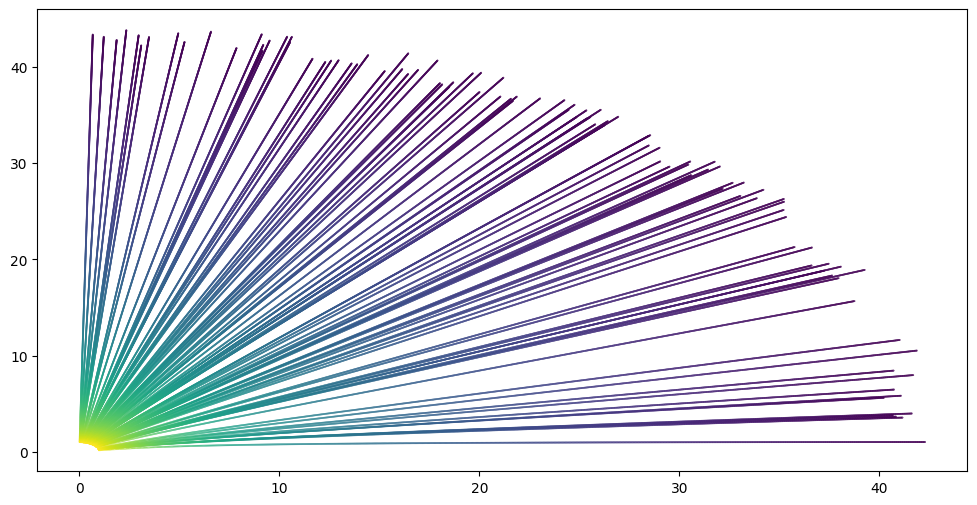

In [128]:
# lets see the first 100 orbits sorted by ejection velocity
mask  = np.argsort(vej)[:100]
R_slow =  R[mask]
z_slow = z[mask]
VR_slow = VR[mask]
Vz_slow = Vz[mask]
t_slow = t[mask]
x_slow = x[mask]
y_slow = y[mask]
z_slow = z[mask]
vx_slow = vx[mask]
vy_slow = vy[mask]
vz_slow = vz[mask]
vej_slow = vej[mask]

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
for i in range(100):
    ax.scatter(x_slow[i], z_slow[i], c = (vx_slow[i]**2 + vz_slow[i]**2)**0.5,s = 0.1)
    #ax.scatter(R_slow[i], z_slow[i], c = np.tile(vej_slow[i], len(z_slow[i])), s = 0.1)
#plt.yscale('log')


#plt.xlim(0, 20)
#plt.ylim(0, 20)
plt.show()

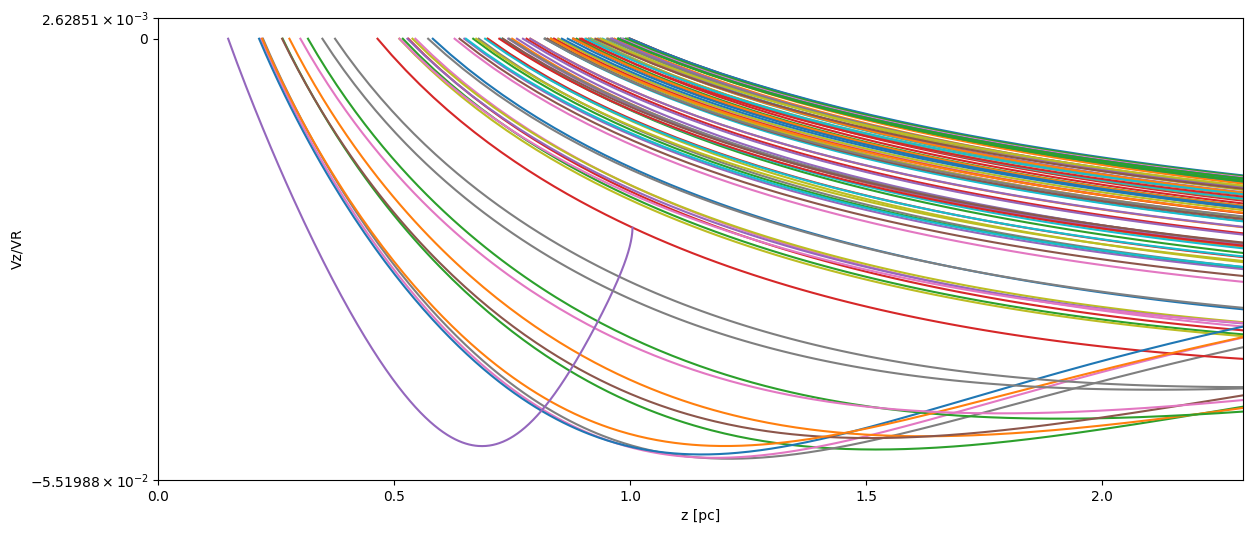

In [129]:
# plot Vz/VR vs z for a range of R
# REPLICATE SERGEY PLOT

plt.figure(figsize=(14, 6))
for i in range(0, 100):
    plt.plot(z_slow[i], Vz_slow[i]/VR_slow[i])
plt.xlabel('z [pc]')
plt.ylabel('Vz/VR')
plt.yscale('symlog')
plt.xlim(0, 2.3)
#plt.ylim(-0.06, 0)
plt.show()

In [130]:
# compute the extra term for each object
R0, V0 = compute_R0_V0_SI()
R_vector = np.array([x.flatten(), y.flatten(), z.flatten()]).T
V_vector = np.array([vx.flatten(), vy.flatten(), vz.flatten()]).T
Omega_vector = np.cross(R_vector, V_vector, axis=-1) # This is now Omega(R, z, theta_ej, v_ej)


In [131]:
# lets visualize Omega as a function of radius and z
# Since we know that Omega will always be in the Y component, we can plot it as a function of R and z

Omega_amplitude = Omega_vector[:,1]

In [126]:
import matplotlib.pyplot as plt

from scipy.stats import binned_statistic_2d

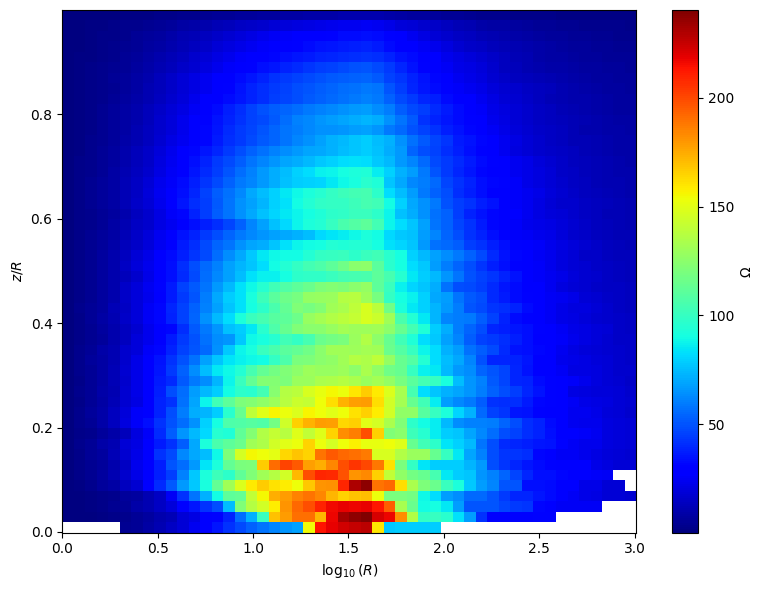

In [143]:

# Choose how many bins you want in each dimension
xbins = 50  # bins in z
ybins = 50  # bins in log10(VR)

zf = z.flatten()
VRf = VR.flatten()
Vzf = Vz.flatten()
Rf = R.flatten()



# Use binned_statistic_2d to compute the mean ratio in each (z, logVR) bin
# statistic='mean' can also be 'median', 'count', 'sum', etc.
stat, xedges, yedges, binnum = binned_statistic_2d(
    y=zf/Rf,
    x=np.log10(Rf),
    values=np.abs(Omega_amplitude),
    statistic='mean',
    bins=[xbins, ybins]
)

# 'stat' is a 2D array of the same shape as bins: (xbins, ybins)
# We can plot it with pcolormesh (or imshow).
plt.figure(figsize=(8, 6))
# Note that stat is indexed as stat[ix, iy], but pcolormesh expects
# xedges (length xbins+1) along the horizontal axis, yedges (length ybins+1)
# along the vertical axis, so we transpose 'stat' in pcolormesh.
plt.pcolormesh(xedges, yedges, stat.T, cmap='jet', shading='auto')#, vmin= 0, vmax= 2e3)

# Colorbar labeling
cb = plt.colorbar()
cb.set_label(r'$\Omega$ ')

plt.xlabel(r'$\log_{10}(R)$')
plt.ylabel(r'$z/R$')
#plt.title(r'')
plt.tight_layout()
#plt.xlim(-2, 2)
plt.show()

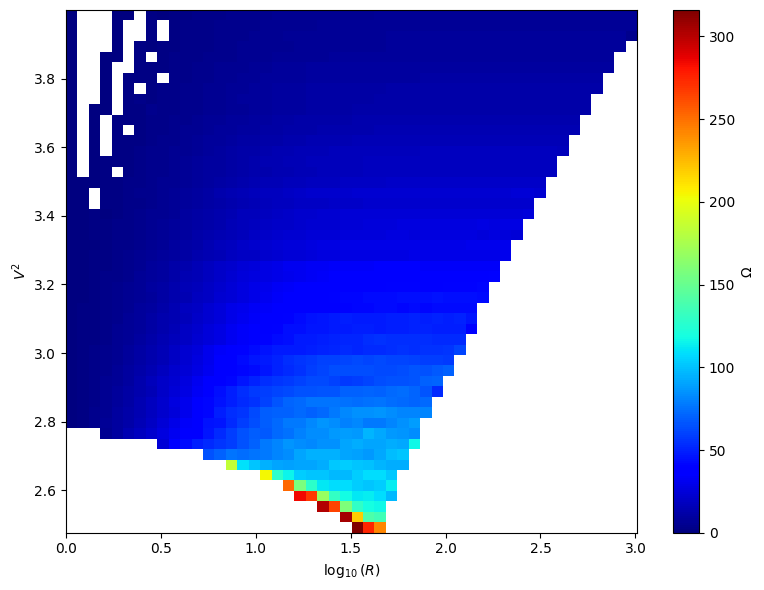

In [13]:

# Choose how many bins you want in each dimension
xbins = 50  # bins in z
ybins = 50  # bins in log10(VR)

zf = z.flatten()
VRf = VR.flatten()
Vzf = Vz.flatten()
Rf = R.flatten()
V_tot = (vx.flatten()**2 + vz.flatten()**2)**0.5


# Use binned_statistic_2d to compute the mean ratio in each (z, logVR) bin
# statistic='mean' can also be 'median', 'count', 'sum', etc.
stat, xedges, yedges, binnum = binned_statistic_2d(
    y= np.log10(V_tot+1e-9), # to avoid log(0) we add a small number
    x=np.log10(Rf),
    values=np.abs(Omega_amplitude),
    statistic='mean',
    bins=[xbins, ybins]
)

# 'stat' is a 2D array of the same shape as bins: (xbins, ybins)
# We can plot it with pcolormesh (or imshow).
plt.figure(figsize=(8, 6))
# Note that stat is indexed as stat[ix, iy], but pcolormesh expects
# xedges (length xbins+1) along the horizontal axis, yedges (length ybins+1)
# along the vertical axis, so we transpose 'stat' in pcolormesh.
plt.pcolormesh(xedges, yedges, stat.T, cmap='jet', shading='auto')#, vmin= 0, vmax= 2e3)

# Colorbar labeling
cb = plt.colorbar()
cb.set_label(r'$\Omega$ ')

plt.xlabel(r'$\log_{10}(R)$')
plt.ylabel(r'$V^2$')
#plt.title(r'')
plt.tight_layout()
#plt.xlim(-2, 2)
plt.show()

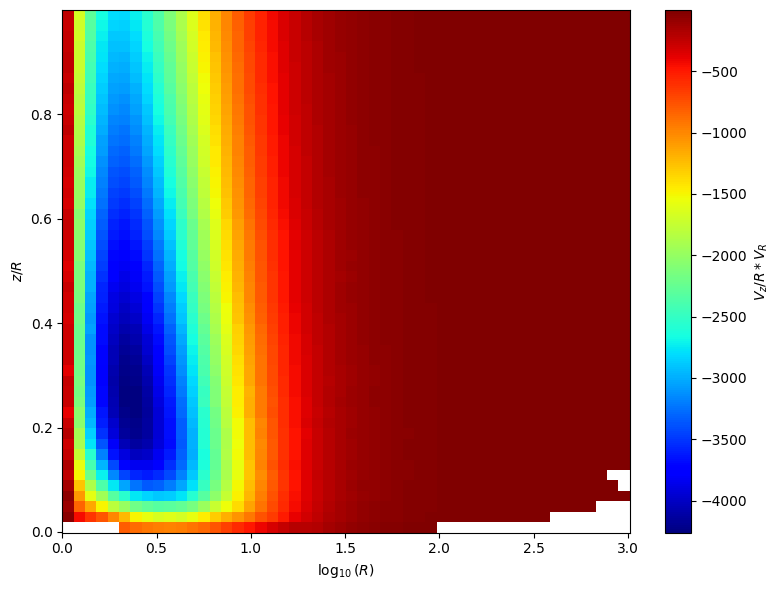

In [154]:
import gala.potential as gp
import gala.integrate as gi
import gala.dynamics as gd
import astropy.units as auni
import astropy.coordinates as acoo
import numpy as np

pot = gp.MilkyWayPotential2022()
kms = auni.km / auni.s

acoo.galactocentric_frame_defaults.set('latest')


def doit(vej, cosang, t):
    #cosang = np.cos(ang)
    #sinang = np.sin(ang)
    sinang = np.sqrt(1 - cosang**2)
    startpos = np.array([cosang, 0, sinang]) * auni.kpc # changed this because ejecting from a 1kpc sphere is too much
    vel = np.array([cosang, 0, sinang]) * vej
    w0 = gd.PhaseSpacePosition(startpos, vel=vel * kms)
    nsteps = 1000
    timestep = t * auni.Myr / nsteps
    orbit = gp.Hamiltonian(pot).integrate_orbit(
        w0,
        dt=timestep,
        n_steps=nsteps,
        Integrator=gi.DOPRI853Integrator,
        # Integrator_kwargs = dict(atol=1e-15,rtol=1e-15)
    )
    R = (orbit.x**2 + orbit.z**2 + orbit.y**2)**.5
    z = orbit.z.to_value(auni.kpc)
    VR = orbit.v_x * R / orbit.x
    Vz = orbit.v_z - orbit.v_x * orbit.z / orbit.x
    return R.to_value(auni.kpc), z, VR.to_value(kms), Vz.to_value(kms)


def doall(N=10000, seed=3):
    rng = np.random.default_rng(seed)
    vej = 10**rng.uniform(2.8, 4, size=N)
    cosa = rng.uniform(0, 1, size=N)
    times = 100
    r1, r2, r3, r4 = [], [], [], []
    for curv, curc in zip(vej, cosa):
        R, z, VR, Vz = doit(curv, curc, times)
        r1.append(R)
        r2.append(z)
        r3.append(VR)
        r4.append(Vz)

    return [np.array(_) for _ in [r1, r2, r3, r4]]

R, z, VR, Vz = doall(10000, 3)



# Choose how many bins you want in each dimension
xbins = 50  # bins in z
ybins = 50  # bins in log10(VR)

# Flatten to go from (10000, 1000) to (10000000,)
zf = z.ravel()
VRf = VR.ravel()
Vzf = Vz.ravel()
Rf = R.ravel()



# Use binned_statistic_2d to compute the mean ratio in each (z, logVR) bin
# statistic='mean' can also be 'median', 'count', 'sum', etc.
stat, xedges, yedges, binnum = binned_statistic_2d(
    y= zf/Rf, # to avoid log(0) we add a small number
    x=np.log10(Rf),
    values=Vzf/Rf*VRf,
    statistic='mean',
    bins=[xbins, ybins]
)

# 'stat' is a 2D array of the same shape as bins: (xbins, ybins)
# We can plot it with pcolormesh (or imshow).
plt.figure(figsize=(8, 6))
# Note that stat is indexed as stat[ix, iy], but pcolormesh expects
# xedges (length xbins+1) along the horizontal axis, yedges (length ybins+1)
# along the vertical axis, so we transpose 'stat' in pcolormesh.
plt.pcolormesh(xedges, yedges, stat.T, cmap='jet', shading='auto')#, vmin= 0, vmax= 2e3)

# Colorbar labeling
cb = plt.colorbar()
cb.set_label(r'$V_z/R*V_R$ ')

plt.xlabel(r'$\log_{10}(R)$')
plt.ylabel(r'$z/R$')
#plt.title(r'')
plt.tight_layout()
#plt.xlim(
# -2, 2)
plt.show()

In [33]:
import numpy as np
from scipy.spatial import cKDTree
from scipy.interpolate import LinearNDInterpolator

class OrbitInterpolator2D:
    def __init__(self, R, z, VR, Vz, Omega):
        """
        Initialize the interpolator with precomputed orbit data.

        Parameters:
        - R, z, VR, Vz, t: 2D arrays of shape (n_orbits, n_points_per_orbit).
        """
        # Flatten the data
        self.R = R.flatten()
        self.z = z.flatten()
        self.VR = VR.flatten()
        self.Vz = Vz.flatten()
        self.Vtot = np.sqrt(self.VR**2 + self.Vz**2)

        # Omega should be a flattened array of just the Y component
        self.Omega = Omega 
        assert np.all(self.Omega > 0), "All Omega values should be positive!"


        # Create a KDTree for efficient nearest-neighbor search
        self.tree = cKDTree(np.column_stack((self.R, self.z, self.VR, self.Vz)))

        # Create an interpolator for Vz
        self.interpolator = LinearNDInterpolator(
            np.column_stack((self.R, self.z, self.VR, self.Vz)),
            self.Omega
        )
    
    def query(self, R, z, VR, Vz):
        """
        Query the interpolator to find Vz for a given R, z, and total velocity.

        Parameters:
        - R, z, Vtot: Input parameters to match.

        Returns:
        - Interpolated Vz value.
        """
        # Find the nearest neighbor if interpolation fails
        dist, idx = self.tree.query([R, z, VR, Vz])
        Omega_nearest = self.Vz[idx]

        # Try to interpolate Vz
        Omega_interp = self.interpolator(R, z, VR, Vz)
        if np.isnan(Omega_interp):  # Fall back to nearest neighbor
            return Omega_nearest
        return Omega_interp


In [34]:
# select points within a range of R

Rf = R.flatten()
zf = z.flatten()
VRf = VR.flatten()
Vzf = Vz.flatten()
tf = t.flatten()

In [35]:
# Build interpolator for a range of R
mask = (Rf > 8) & (Rf < 9)
R_subset = Rf[mask]
z_subset = zf[mask]
VR_subset = VRf[mask]
Vz_subset = Vzf[mask]
Omega_subset = Omega_amplitude[mask]


In [36]:
interpolator_Omega = OrbitInterpolator2D(R_subset, z_subset, VR_subset, Vz_subset, Omega_subset)

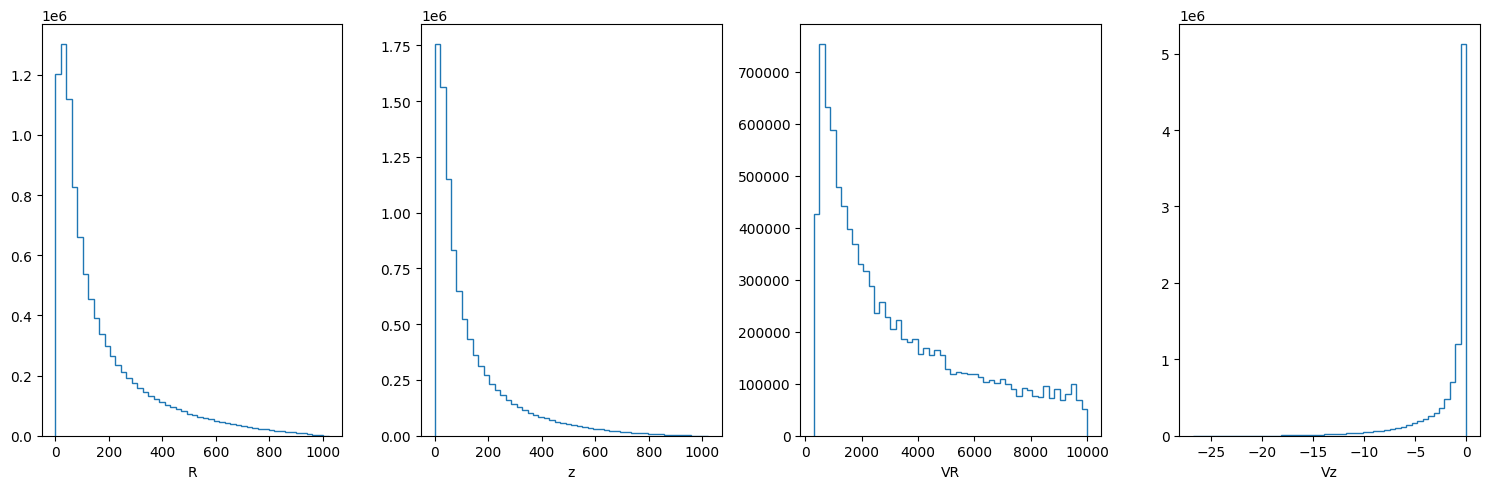

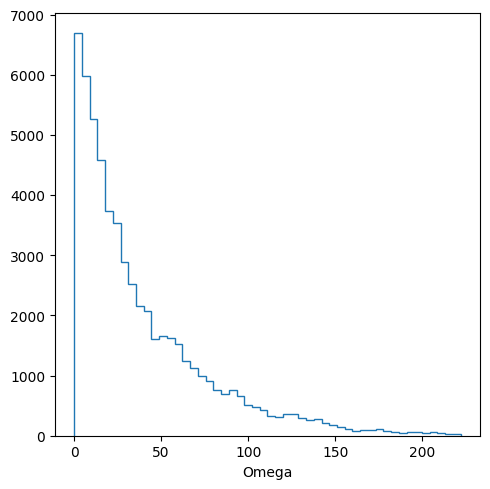

In [39]:
# plot histograms of all the parameters to know the range of interpolation
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
ax[0].hist(Rf, bins=50, histtype='step')
ax[0].set_xlabel('R')

ax[1].hist(zf, bins=50, histtype='step')
ax[1].set_xlabel('z')

ax[2].hist(VRf, bins=50, histtype='step')
ax[2].set_xlabel('VR')

ax[3].hist(Vzf, bins=50, histtype='step')
ax[3].set_xlabel('Vz')

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(Omega_subset, bins=50, histtype='step')
ax.set_xlabel('Omega')
plt.tight_layout()
plt.show()

# Test the interpolator

We will test with some value that is in the inputs and then apply a small offset

In [44]:
index_test = 10000
test_point = [R_subset[index_test], z_subset[index_test], VR_subset[index_test], Vz_subset[index_test]]

Omega_interp = interpolator_Omega.query(*test_point)

print(f"Interpolated Omega: {Omega_interp}")

Interpolated Omega: 16.728764970415796


In [49]:
index_test = 10000
test_point = [R_subset[index_test] + 0.1, z_subset[index_test] + 0.1, VR_subset[index_test] + 0.1, Vz_subset[index_test]]

Omega_interp = interpolator_Omega.query(*test_point)

print(f"Interpolated Omega: {Omega_interp}")

Interpolated Omega: 15.664842446173958


In [ ]:
# now we need a function that takes the ra, dec, pmra, pmdec, implied distance and radial velocity and transforms them to cylindrical coordinates
import astropy.units as u
from astropy.coordinates import SkyCoord

def compute_cylindrical_coordinates(ra, dec, pmra, pmdec, d, vr):
    cords = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, pm_ra_cosdec=pmra*u.mas/u.yr, pm_dec=pmdec*u.mas/u.yr, distance=d*u.pc, radial_velocity=vr*u.km/u.s)
    gal = cords.transform_to(coord.Galactocentric)
    R = np.sqrt(gal.x**2 + gal.y**2).value
    z = gal.z.value
    VR = (gal.v_x * R / gal.x).value
    Vz = (gal.v_z - gal.v_x * gal.z / gal.x).value
    return R, z, VR, Vz

def compute_correction


In [ ]:
# Build interpolator so that given a source we can find Vz
# This interpolating function should be able to take in a source ra, dec, pmra, pmdec, D_i and Vr_i and return Vz
# For this purpose the function should turn the gaia 6D phase space coordinates into galactocentric cylindrical coordinates
